In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline  # Use imbalanced-learn's Pipeline for resampling
import joblib
import pickle

In [8]:
# Read Data
df = pd.read_csv(r"C:\Users\khes7001\OneDrive - NIQ\Desktop\New folder (2)\Eslam_Final_Project\Eslam_Final_Project\Sourse\cleaned_data.csv")

In [9]:
# Drop columns 
df.drop(['UserID'], axis=1, inplace=True)

In [10]:
# Split data into features and target variable
X = df.drop('CourseCompletion', axis=1)
y = df['CourseCompletion']

# Identify numerical and categorical columns
numerical_columns = X.select_dtypes(["float64", "int64"]).columns
categorical_columns = X.select_dtypes(["object"]).columns

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)
X = preprocessor.fit_transform(X)

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(),
    'LR': LogisticRegression()
}


In [13]:
# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results[name] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'accuracy_score': accuracy_score(y_test, y_pred)
    }

# Print results
for name, metrics in results.items():
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("Classification Report:")
    print(metrics['classification_report'])
    print(f"Accuracy Score: {metrics['accuracy_score']}\n")

Model: Random Forest
Confusion Matrix:
[[866  32]
 [ 46 698]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       898
           1       0.96      0.94      0.95       744

    accuracy                           0.95      1642
   macro avg       0.95      0.95      0.95      1642
weighted avg       0.95      0.95      0.95      1642

Accuracy Score: 0.9524969549330086

Model: XGBoost
Confusion Matrix:
[[863  35]
 [ 53 691]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       898
           1       0.95      0.93      0.94       744

    accuracy                           0.95      1642
   macro avg       0.95      0.94      0.95      1642
weighted avg       0.95      0.95      0.95      1642

Accuracy Score: 0.9464068209500609

Model: Decision Tree
Confusion Matrix:
[[814  84]
 [ 81 663]]
Classification Report:
              precision  

# Work on the best model(Random Forest)

In [14]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [15]:
# Initialize the Random Forest model
rf = RandomForestClassifier()

In [16]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', 
                           n_jobs=-1, verbose=2)

In [17]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [18]:
# Get the best model and parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

In [19]:
# Predict with the best model
y_pred = best_rf.predict(X_test)

In [20]:
# Store results
results = {
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred),
    'accuracy_score': accuracy_score(y_test, y_pred)
}

# Print results
print("Random Forest Model")
print(f"Best Parameters: {best_params}")
print("Confusion Matrix:")
print(results['confusion_matrix'])
print("Classification Report:")
print(results['classification_report'])
print(f"Accuracy Score: {results['accuracy_score']}\n")

Random Forest Model
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix:
[[865  33]
 [ 46 698]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       898
           1       0.95      0.94      0.95       744

    accuracy                           0.95      1642
   macro avg       0.95      0.95      0.95      1642
weighted avg       0.95      0.95      0.95      1642

Accuracy Score: 0.9518879415347138



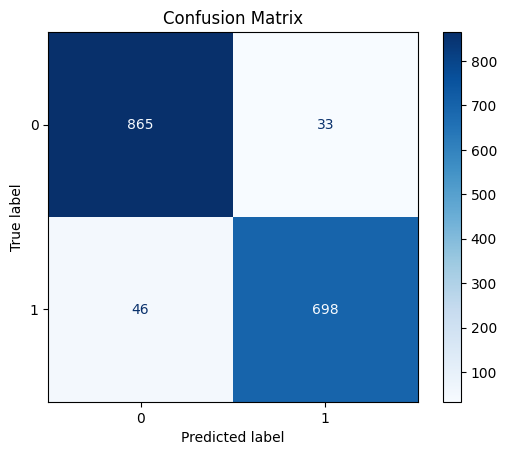

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Save the preprocessor and model to a file
joblib.dump(best_rf, 'best_random_forest_model.joblib')  
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']